C:\Users\cheta\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\cheta\AppData\Local\Temp\ipykernel_6984\3214179146.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=iter(train_loader), steps_per_epoch=np.ceil(len(train_data)/batch_size),


Epoch 1/200
4/4 [==============================] - 8s 2s/step - loss: -0.2200 - dice_coefficient: 0.2245 - val_loss: -0.2361 - val_dice_coefficient: 0.2361 - lr: 1.0000e-04
Epoch 2/200
4/4 [==============================] - 7s 2s/step - loss: -0.2243 - dice_coefficient: 0.2237 - val_loss: -0.2405 - val_dice_coefficient: 0.2405 - lr: 1.0000e-04
Epoch 3/200
4/4 [==============================] - 7s 2s/step - loss: -0.2305 - dice_coefficient: 0.2394 - val_loss: -0.2678 - val_dice_coefficient: 0.2678 - lr: 1.0000e-04
Epoch 4/200
4/4 [==============================] - 7s 2s/step - loss: -0.2656 - dice_coefficient: 0.2703 - val_loss: -0.2859 - val_dice_coefficient: 0.2859 - lr: 1.0000e-04
Epoch 5/200
4/4 [==============================] - 7s 2s/step - loss: -0.2699 - dice_coefficient: 0.2751 - val_loss: -0.2985 - val_dice_coefficient: 0.2985 - lr: 1.0000e-04
Epoch 6/200
4/4 [==============================] - 7s 2s/step - loss: -0.2885 - dice_coefficient: 0.3023 - val_loss: -0.3135 - val_dice

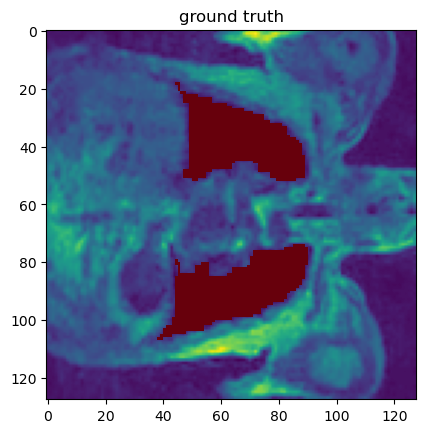

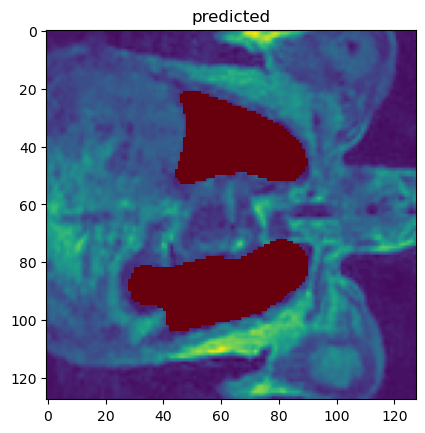

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


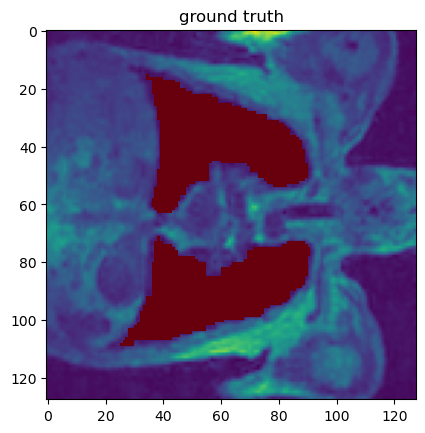

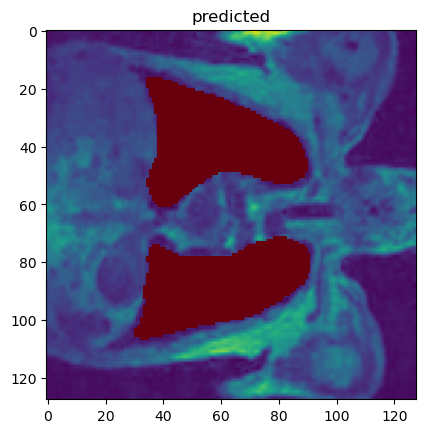

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


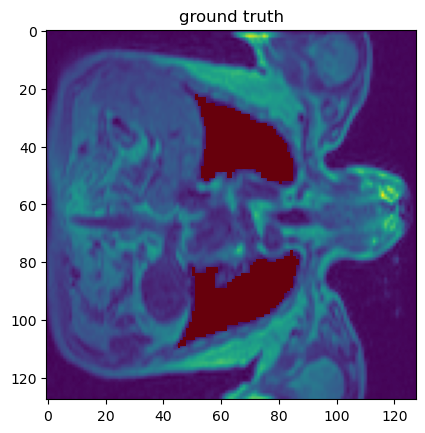

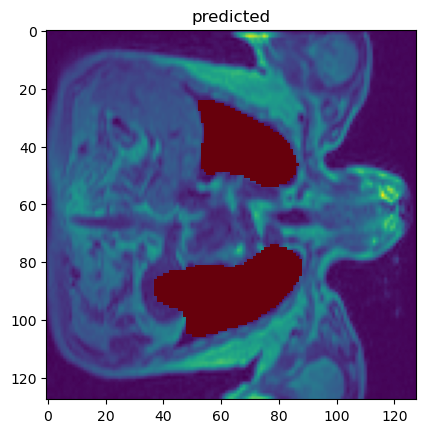

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


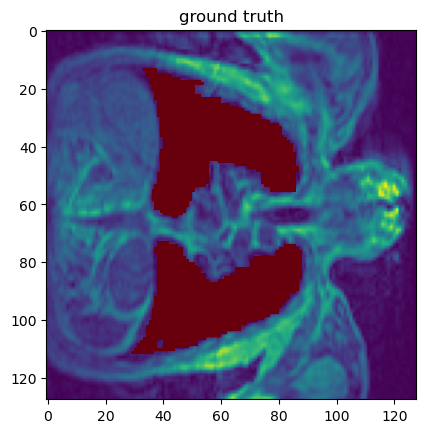

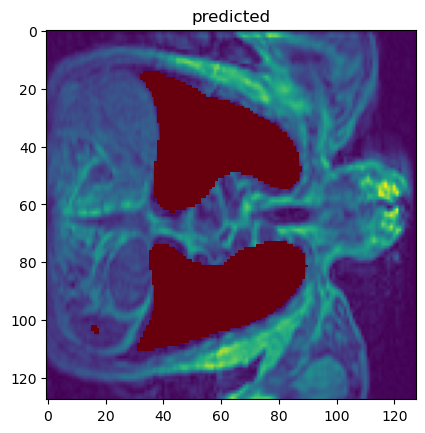

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


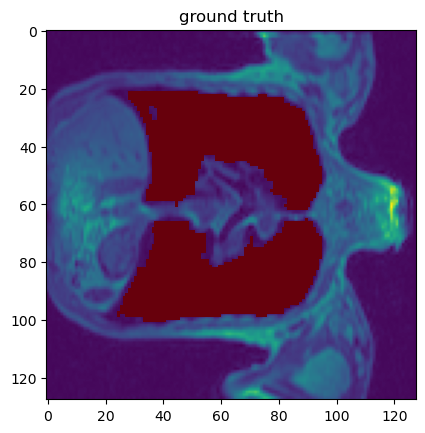

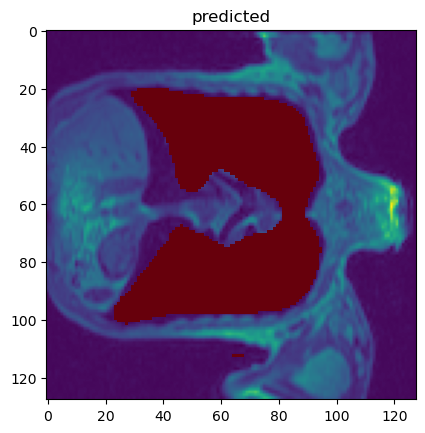

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


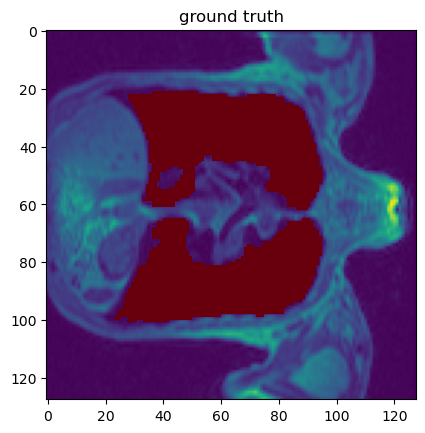

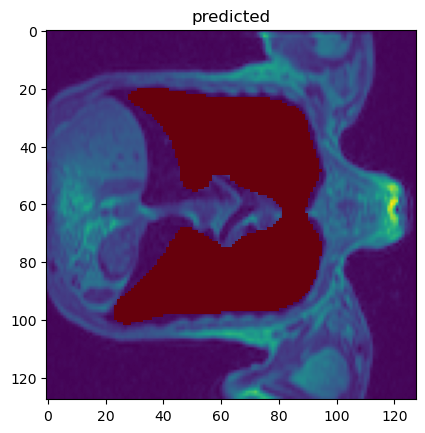

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


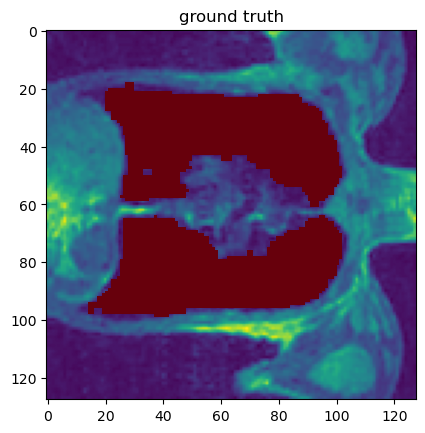

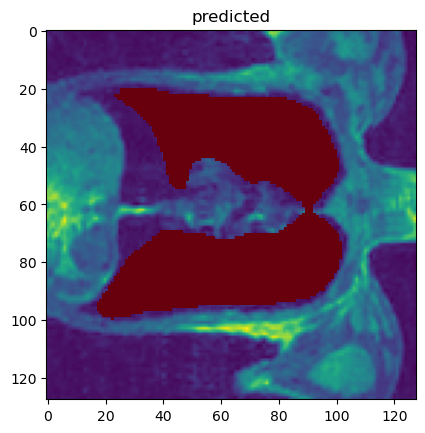

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


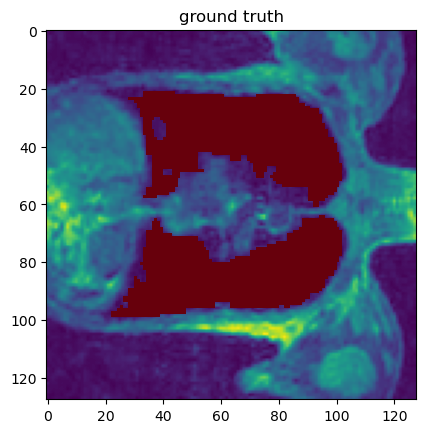

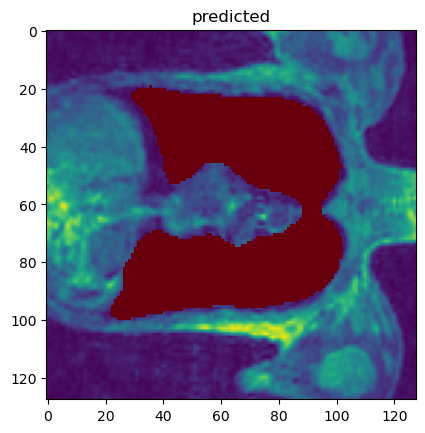

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


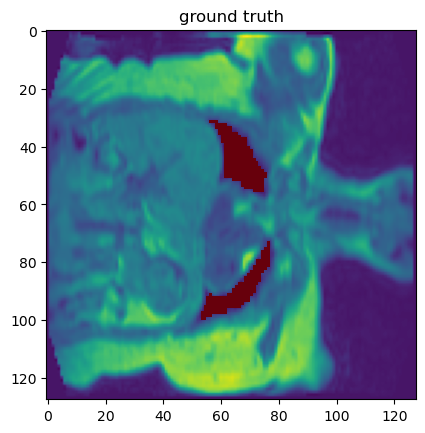

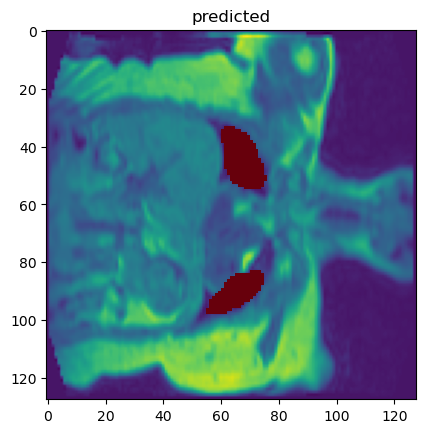

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


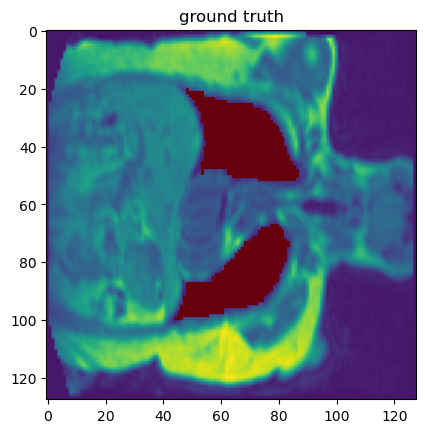

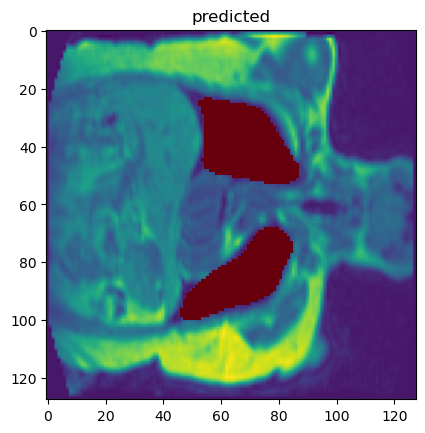

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


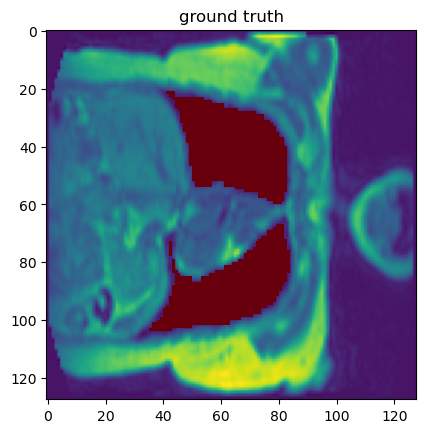

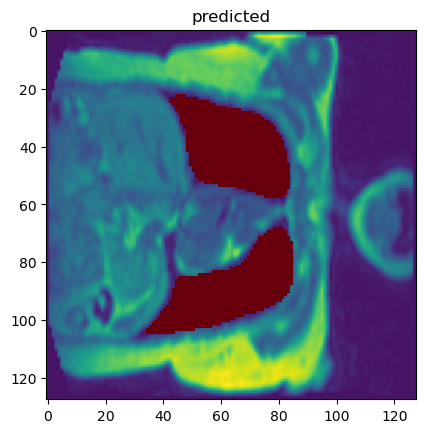

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


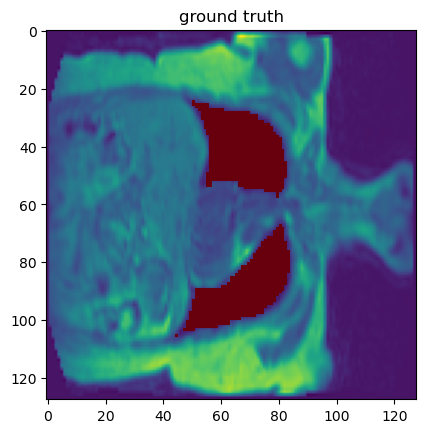

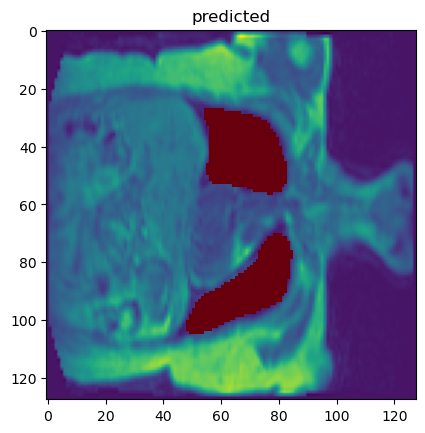

- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -


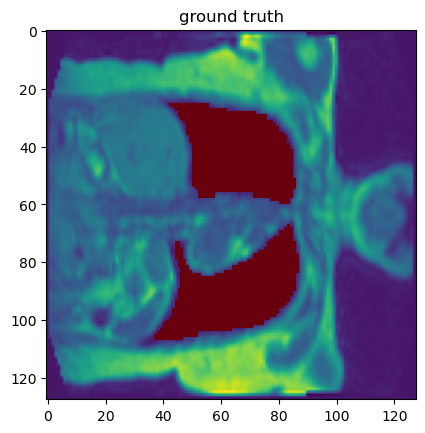

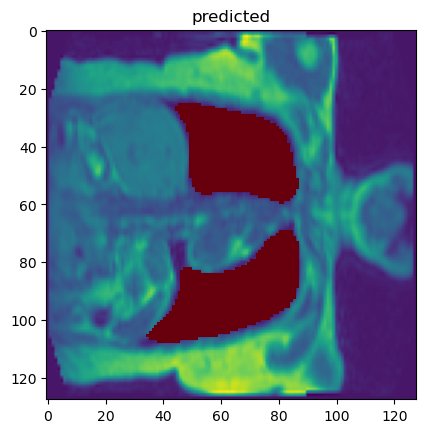

- - - - - - - - - - - - - - - - - - - -


In [2]:

import numpy as np
import os
import matplotlib.pyplot as plt

from keras import callbacks as cbks

base_dir = '/users/cheta/Downloads/unet-ants-master/'
os.chdir(base_dir+'code/')

# local imports
from sampling import DataLoader, CSVDataset
from sampling import transforms as tx
from models import create_unet_model2D


data_dir = base_dir + 'data_2D/'
results_dir = base_dir+'results_2D/'

input_tx = tx.MinMaxScaler((0,1)) # scale input images between 0 and 1
target_tx = tx.BinaryMask(cutoff=0.5) # convert target segmentation to a binary mask

# tx.Compose lets you string together multiple transforms
co_tx = tx.Compose([tx.ExpandDims(axis=-1), # expand from (128,128) to (128,128,1) -> RandomAffine and Keras expect that
                    tx.RandomAffine(rotation_range=(-15,15), # rotate btwn -15 & 15 degrees
                                    translation_range=(0.1,0.1), # translate btwn -10% and 10% horiz, -10% and 10% vert
                                    shear_range=(-10,10), # shear btwn -10 and 10 degrees
                                    zoom_range=(0.85,1.15), # between 15% zoom-in and 15% zoom-out
                                    turn_off_frequency=5) # how often to just turn off random affine transform (units=#samples)
                    ])

# use a co-transform, meaning the same transform will be applied to input+target images at the same time 
# this is necessary since Affine transforms have random parameter draws which need to be shared
dataset = CSVDataset(filepath=data_dir+'image_filemap.csv', 
                    base_path=data_dir, # this path will be appended to all of the filenames in the csv file
                    input_cols=['images'], # column in dataframe corresponding to inputs (can be an integer also)
                    target_cols=['masks'],# column in dataframe corresponding to targets (can be an integer also)
                    input_transform=input_tx, target_transform=target_tx, co_transform=co_tx)


# split into train and test set based on the `train-test` column in the csv file
# this splits alphabetically by values, and since 'test' comes before 'train' thus val_data is returned before train_data
val_data, train_data = dataset.split_by_column('train-test')

# overwrite co-transform on validation data so it doesnt have any random augmentation
val_data.set_co_transform(tx.ExpandDims(axis=-1))

# create a dataloader .. this is basically a keras DataGenerator -> can be fed to `fit_generator`
batch_size = 15
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# write an example batch to a folder as JPEG
#train_loader.write_a_batch(data_dir+'example_batch/')

# create model
model = create_unet_model2D(input_image_size=train_data[0][0].shape, n_labels=1, layers=4)

callbacks = [cbks.ModelCheckpoint(results_dir+'weights-py.h5', monitor='val_loss', save_best_only=True),
            cbks.ReduceLROnPlateau(monitor='val_loss', factor=0.1)]

model.fit_generator(generator=iter(train_loader), steps_per_epoch=np.ceil(len(train_data)/batch_size), 
                    epochs=200, verbose=1, callbacks=callbacks, 
                    shuffle=True, 
                    validation_data=iter(val_loader), validation_steps=np.ceil(len(val_data)/batch_size), 
                    class_weight=None, max_queue_size=10, 
                    workers=1, use_multiprocessing=False,  initial_epoch=0)


### RUNNING INFERENCE ON THE NON-AUGMENTED DATA

# load all the validation data into memory.. not at all necessary but easier for this example
real_val_x, real_val_y = val_data.load()

real_val_y_pred = model.predict(real_val_x)
real_val_y_pred[real_val_y_pred>=0.5] = 1
real_val_y_pred[real_val_y_pred<0.5] = 0

real_val_y_pred_plot = real_val_y_pred.copy()
real_val_y_pred_plot[real_val_y_pred_plot!=1]=None
real_val_y_plot = real_val_y.copy()
real_val_y_plot[real_val_y_plot!=1]=None

save_fig = False
for i in range(len(val_data)):
    print(*['-']*20)
    plt.imshow(real_val_x[i,:,:,0])
    plt.imshow(real_val_y_plot[i,:,:,0],cmap='Reds_r')
    plt.title('ground truth')
    if save_fig:
        plt.savefig(results_dir+'predictions/%02i_truth.png'%i)
        plt.clf()
    else:
        plt.show()
    plt.imshow(real_val_x[i,:,:,0])
    plt.imshow(real_val_y_pred_plot[i,:,:,0],cmap='Reds_r')
    plt.title('predicted')
    if save_fig:
        plt.savefig(results_dir+'predictions/%02i_pred.png'%i)
        plt.clf()
    else:
        plt.show()
    print(*['-']*20)